In [7]:
from typing import List, Tuple
import getpass
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator
from qiskit.circuit import Parameter
from qiskit.circuit.gate import Gate
from qiskit.circuit.library import UGate, RXGate, RYGate, RZGate, TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA, CG, ADAM, AQGD
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [8]:
channel = "ibm_quantum"
try:
    service = QiskitRuntimeService(channel=channel)
except Exception:
    QiskitRuntimeService.save_account(channel=channel, token=getpass.getpass('Enter IBM Quantum token'), overwrite=True)
    service = QiskitRuntimeService(channel=channel)

In [9]:
service.backends()

[<IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_brisbane')>]

In [10]:
backend = "ibmq_qasm_simulator"

In [234]:
n = 4
q = 2
img_shape = (n, n, 1)

In [222]:
def b_num(num: int) -> str:
    return f"{num:b}"

def is_power_of_two(num) -> bool:
    b = b_num(num)
    return b.startswith("1") and (b[1:] == "0" * (len(b) - 1))

def n_qubits() -> int:
    pixels = n ** 2
    pixels_per_group = 2 ** q
    div_groups = pixels // pixels_per_group
    mod_groups = pixels % pixels_per_group
    return (q * (div_groups + (1 if mod_groups > 0 else 0)))

def scale_parameter(value: int, upper_limit: int=255) -> float:
    assert 0 <= value <= upper_limit
    return np.pi * (value / upper_limit) + np.pi / 2

In [13]:
def transpiled_depth(qc, backend_name) -> int:
    my_backend = service.backends(backend_name)[0]
    return transpile(qc, backend=my_backend).depth()

In [235]:
n_qubits()

8

In [14]:
u = UGate(theta=Parameter("theta"), phi=Parameter("phi"), lam=0)
u.params

[Parameter(theta), Parameter(phi), 0]

In [455]:
def rebind_gate_params(gate: Gate, start_index=0) -> Tuple[Gate, List[Parameter], int]:
    gate_counter = start_index
    my_gate = gate.copy()
    new_params = []
    for p in range(len(my_gate.params)):
        if not isinstance(my_gate.params[p], Parameter):
            continue
        new_params.append(Parameter(f"theta[{gate_counter}]"))
        my_gate.params[p] = new_params[-1]
        gate_counter += 1
    return my_gate, new_params, gate_counter

def create_classifier_circuit(img_shape: tuple, qubits_per_group: int, gates: List[Gate]) -> Tuple[QuantumCircuit, QuantumCircuit]:
    assert qubits_per_group in (2, 3)
    assert len(img_shape) == 3
    shape = (img_shape[0] * img_shape[1], )
    pixels_per_group = 2 ** qubits_per_group
    div_groups = shape[0] // pixels_per_group
    mod_groups = shape[0] % pixels_per_group
    n_groups = div_groups + (1 if mod_groups > 0 else 0)
    assert n_groups * qubits_per_group < 127
    image_qc = QuantumCircuit(n_groups * qubits_per_group)
    ansatz_qc = QuantumCircuit(n_groups * qubits_per_group)
    gate_counter = 0
    image_params = []
    for g in range(n_groups):
        qubits = list(range(g * qubits_per_group, g * qubits_per_group + qubits_per_group))
        image_qc.h(qubits[:-1])
        for state in range(pixels_per_group // 2):
            if (g * pixels_per_group) + (2 * state) >= shape[0] - 1:
                break
            for gate in gates:
                new_gate, new_params, gate_counter = rebind_gate_params(gate, gate_counter)
                image_params += new_params
                new_gate = new_gate.control(qubits_per_group - 1, ctrl_state=state)
                image_qc.append(new_gate, qubits)
        image_qc.h(qubits[:-1])
    ans_theta = Parameter(f"ans_theta{g}")
    ans_phi = Parameter(f"ans_phi{g}")
    ansatz_qc.append(
        TwoLocal(
            num_qubits=n_groups * qubits_per_group,
            rotation_blocks=[UGate(ans_theta, ans_phi, 0)],
            entanglement_blocks="cx",
            entanglement="full",
            reps=1,
            insert_barriers=True,
            skip_final_rotation_layer=False,
            parameter_prefix=f"T{g}"
        ).decompose(),
        range(n_groups * qubits_per_group)
    )
    qc = QuantumCircuit(
        n_groups * qubits_per_group
    ).compose(
        image_qc, range(n_groups * qubits_per_group)
    )
    qc.barrier()
    #for g in range(n_groups - 1):
    #    for i in range(qubits_per_group):
    #        qc.cx(g * qubits_per_group + i, g * qubits_per_group + i + qubits_per_group)
    #qc.barrier()
    qc = qc.compose(
        ansatz_qc, range(n_groups * qubits_per_group)
    )
    return qc, image_params, ansatz_qc.parameters

In [401]:
def create_random_image(rng: tuple=(0, 255)) -> np.ndarray:
    assert len(rng) == 2
    assert 0 <= rng[0] <= 255
    assert 0 <= rng[1] <= 255
    assert rng[0] < rng[1]
    return np.rint(np.random.random(img_shape) * (rng[1] - rng[0]) + rng[0]).astype(np.uint8)

In [402]:
def generate_dataset_dl(num: int):
    images = []
    labels = []
    dark = (0, 155)
    light = (100, 255)
    for i in range(num):
        lbl = np.random.randint(0, 2)
        if 0 == lbl:
            images.append(create_random_image(dark))
            labels.append(-1)
        else:
            images.append(create_random_image(light))
            labels.append(1)
    return images, labels

In [282]:
def generate_dataset_vh(num: int):
    images = []
    labels = []
    for i in range(num):
        lbl = np.random.randint(0, 2)
        images.append(create_random_image((80, 255)))
        if 0 == lbl: # horizontal
            labels.append(-1)
            length = np.random.randint(img_shape[1] - 1, img_shape[1] + 1)
            line = np.array([[0]] * length)
            row = np.random.randint(0, img_shape[0])
            if length == img_shape[1]:
                images[-1][row, :] = line
            else:
                start = np.random.randint(0, img_shape[1] - length + 1)
                images[-1][row, start:start+length] = line
        else: # vertical
            labels.append(1)
            length = np.random.randint(img_shape[0] - 1, img_shape[0] + 1)
            line = np.array([[0]] * length)
            col = np.random.randint(0, img_shape[1])
            if length == img_shape[0]:
                images[-1][:, col] = line
            else:
                start = np.random.randint(0, img_shape[0] - length + 1)
                images[-1][start:start+length, col] = line
    return images, labels

In [283]:
def reshape_and_rescale(img):
    return list(map(scale_parameter, img.reshape((img.shape[0] * img.shape[1],))))

Label: dark
Dark: 50; Light: 50


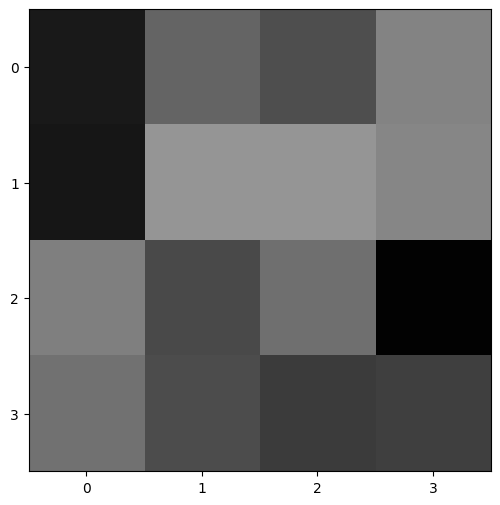

In [485]:
images, labels = generate_dataset_dl(100)
train_images, test_images, train_labels, test_labels = train_test_split(
    list(map(reshape_and_rescale, images)), labels, test_size=0.2
)
image = images[15]
print(f"Label: {['dark', 'light'][(labels[15] + 1) // 2]}")
print(f"Dark: {labels.count(-1)}; Light: {labels.count(1)}")
plt.imshow(image, cmap="gray", vmin=0, vmax=255)
plt.xticks(np.arange(n), np.arange(n))
plt.yticks(np.arange(n), np.arange(n))
plt.show()

In [21]:
print(images[0])
print(reshape_and_rescale(images[0]))

[[[207]
  [176]
  [151]
  [210]]

 [[179]
  [207]
  [222]
  [174]]

 [[115]
  [130]
  [121]
  [227]]

 [[151]
  [248]
  [158]
  [202]]]
[2.550234036443479, 2.1683149295364847, 1.8603156497727795, 2.5871939500151235, 2.2052748431081293, 2.550234036443479, 2.7350336043017025, 2.1436749871553884, 1.416796686913044, 1.601596254771267, 1.4907165140563332, 2.796633460254443, 1.8603156497727795, 3.0553528552559555, 1.946555448106617, 2.488634180490738]


Label: vertical
Horizontal: 48; Vertical: 52


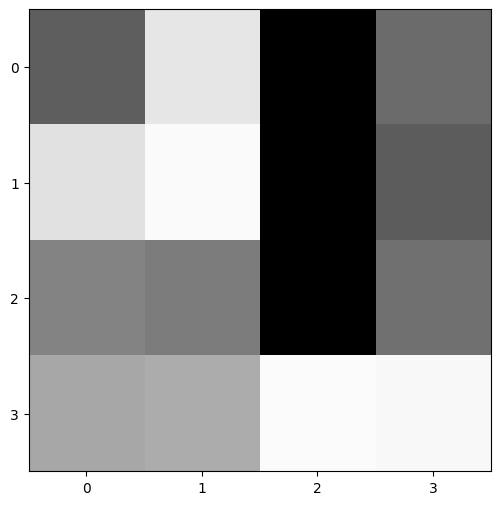

In [225]:
images, labels = generate_dataset_vh(100)
train_images, test_images, train_labels, test_labels = train_test_split(
    list(map(reshape_and_rescale, images)), labels, test_size=0.2
)
image = images[15]
print(f"Label: {['horizontal', 'vertical'][(labels[15] + 1) // 2]}")
print(f"Horizontal: {labels.count(-1)}; Vertical: {labels.count(1)}")
plt.imshow(image, cmap="gray", vmin=0, vmax=255)
plt.xticks(np.arange(n), np.arange(n))
plt.yticks(np.arange(n), np.arange(n))
plt.show()

In [456]:
theta = Parameter("theta")
phi = Parameter("phi")
# classifier_qc, input_params, weight_params = create_classifier_circuit(img_shape, q, [UGate(theta=theta, phi=phi, lam=0)])
classifier_qc, input_params, weight_params = create_classifier_circuit(img_shape, q, [RYGate(theta=theta), RZGate(phi=phi)])
print(f"Original depth: {classifier_qc.depth()}, Transpiled depth: {transpiled_depth(classifier_qc, 'ibm_kyoto')}")
classifier_qc.parameters

Original depth: 7, Transpiled depth: 321


ParameterView([ParameterVectorElement(T3[0]), ParameterVectorElement(T3[1]), ParameterVectorElement(T3[2]), ParameterVectorElement(T3[3]), ParameterVectorElement(T3[4]), ParameterVectorElement(T3[5]), ParameterVectorElement(T3[6]), ParameterVectorElement(T3[7]), ParameterVectorElement(T3[8]), ParameterVectorElement(T3[9]), ParameterVectorElement(T3[10]), ParameterVectorElement(T3[11]), ParameterVectorElement(T3[12]), ParameterVectorElement(T3[13]), ParameterVectorElement(T3[14]), ParameterVectorElement(T3[15]), ParameterVectorElement(T3[16]), ParameterVectorElement(T3[17]), ParameterVectorElement(T3[18]), ParameterVectorElement(T3[19]), ParameterVectorElement(T3[20]), ParameterVectorElement(T3[21]), ParameterVectorElement(T3[22]), ParameterVectorElement(T3[23]), ParameterVectorElement(T3[24]), ParameterVectorElement(T3[25]), ParameterVectorElement(T3[26]), ParameterVectorElement(T3[27]), ParameterVectorElement(T3[28]), ParameterVectorElement(T3[29]), ParameterVectorElement(T3[30]), Par

In [457]:
input_params

[Parameter(theta[0]),
 Parameter(theta[1]),
 Parameter(theta[2]),
 Parameter(theta[3]),
 Parameter(theta[4]),
 Parameter(theta[5]),
 Parameter(theta[6]),
 Parameter(theta[7]),
 Parameter(theta[8]),
 Parameter(theta[9]),
 Parameter(theta[10]),
 Parameter(theta[11]),
 Parameter(theta[12]),
 Parameter(theta[13]),
 Parameter(theta[14]),
 Parameter(theta[15])]

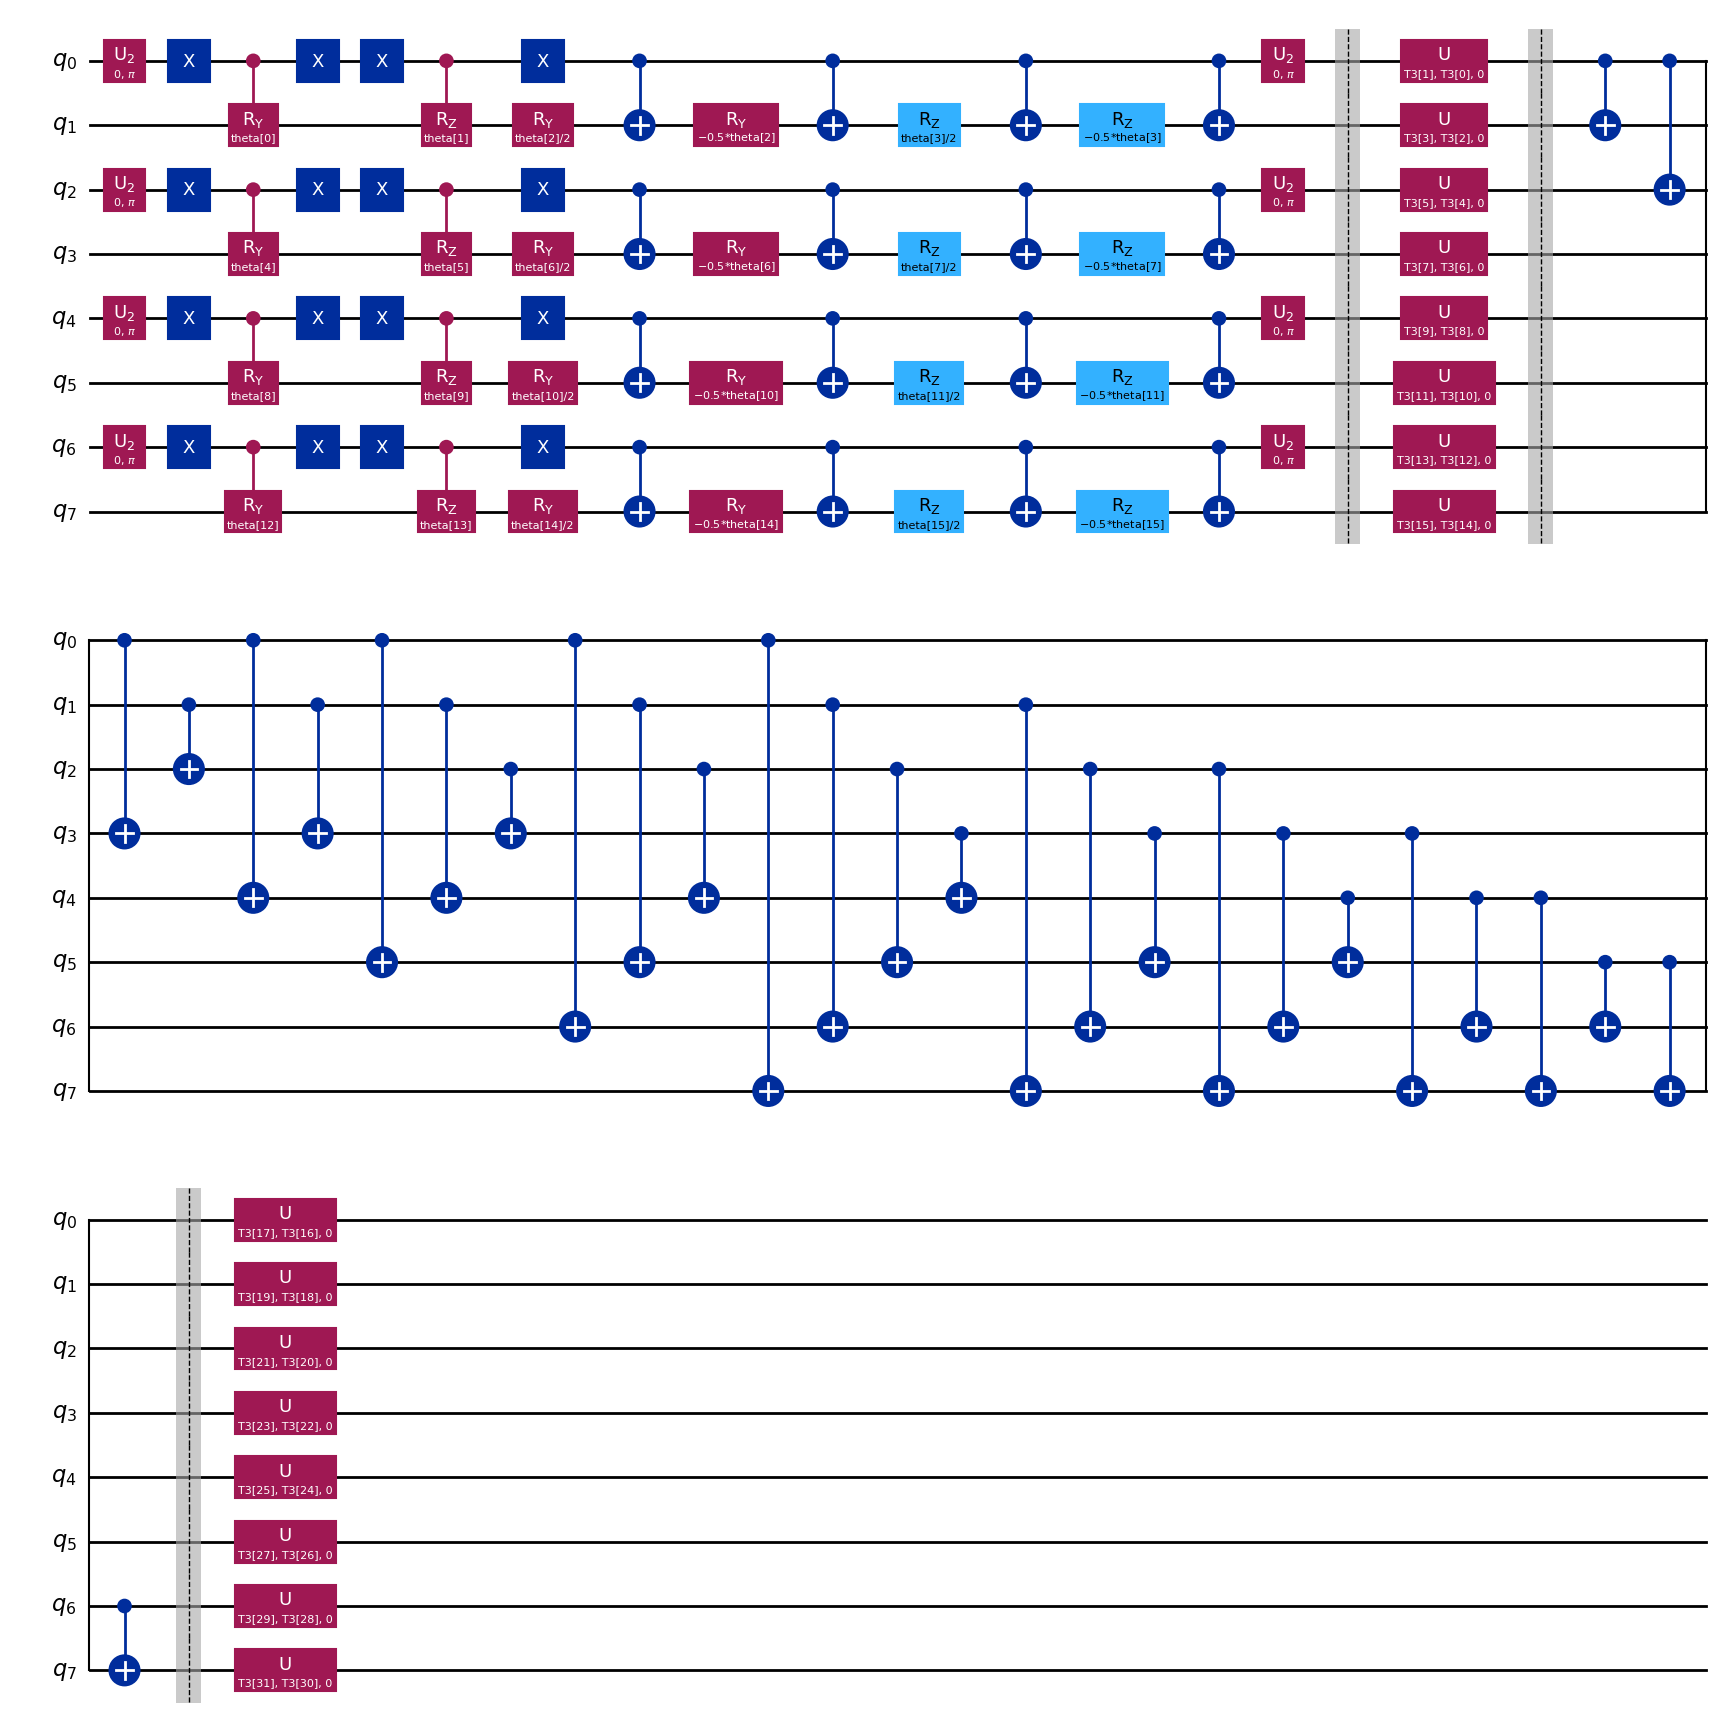

In [458]:
classifier_qc.decompose().draw("mpl", style="iqp")

In [486]:
print(len(input_params))
print(len(weight_params))

16
32


In [487]:
options = Options()
options.simulator.seed_simulator = 42
options.execution.shots = 1000
options.optimization_level = 0 # no optimization
options.resilience_level = 0 # no error mitigation
# observable = SparsePauliOp("Z" * n_qubits())
observable = SparsePauliOp.from_list([("ZZZZZZZZ", 1)])

In [488]:
qnn = EstimatorQNN(
    circuit=classifier_qc.decompose(),
    observables=observable,
    input_params=input_params,
    weight_params=weight_params,
)

In [489]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [490]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=250),  # Set max iterations here
    callback=callback_graph,
    initial_point=np.random.random(len(weight_params)) * np.pi,
    #initial_point=classifier.weights,
)

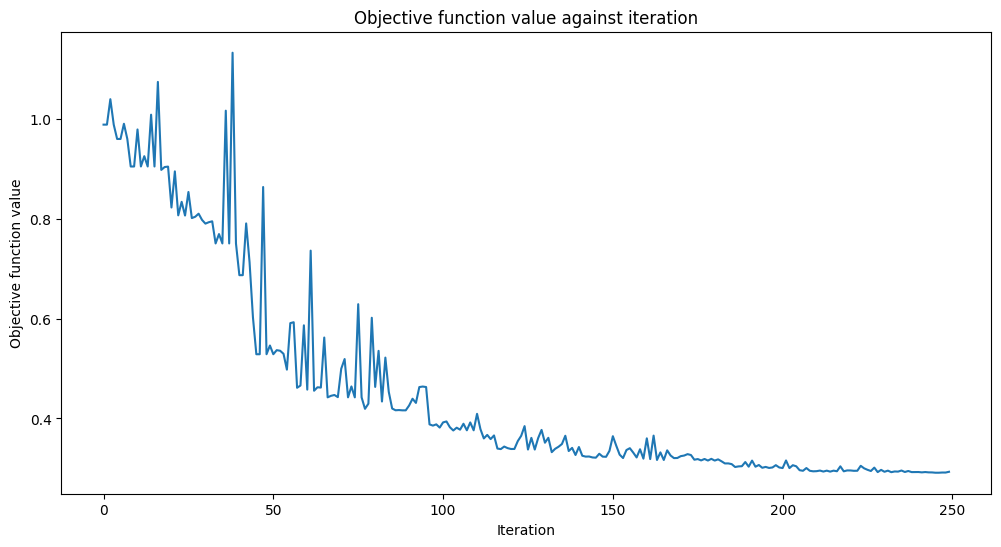

Accuracy from the train data : 97.5%


In [491]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [492]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 100.0%


In [449]:
x0 = classifier.weights

In [497]:
extra_images, extra_labels = generate_dataset_dl(100)
extra_images = list(map(reshape_and_rescale, extra_images))
y_predict = classifier.predict(extra_images)
x = np.asarray(extra_images)
y = np.asarray(extra_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 99.0%


In [ ]:
rnd_img = create_random_image((90, 255))
plt.imshow(rnd_img, cmap="gray", vmin=0, vmax=255)
plt.xticks(np.arange(n), np.arange(n))
plt.yticks(np.arange(n), np.arange(n))
plt.show()
print(f"Prediction: {classifier.predict([reshape_and_rescale(rnd_img)])[0]}")

In [ ]:
service.backends()

In [ ]:
my_qc = QuantumCircuit(3)
u = UGate(np.pi/2, np.pi/4, 0).control(2, ctrl_state=0)
my_qc.append(u, range(3))
my_qc.draw("mpl", style="iqp")

In [ ]:
t_qc = transpile(my_qc, service.backends("ibm_kyoto")[0])
print(f"Depth: {t_qc.depth()}")

In [ ]:
t_qc.draw("mpl", style="iqp")

In [ ]:
service.backends("ibm_osaka")[0].configuration().basis_gates

In [ ]:
service.instances()

In [ ]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider(instance='ibm-q/open/main')


In [ ]:
provider.backends()[4].configuration().basis_gates

In [90]:
from qiskit.circuit.library import RYGate
rz = RYGate(theta=theta)
rz.control(2, ctrl_state=0)

Instruction(name='ccry_o0', num_qubits=3, num_clbits=0, params=[Parameter(theta)])